# News Sentiment Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor

import math
import io
import time

## Load Data

In [2]:
# ! kaggle dataset download -c 'name-of-competition'
# ! unzip train.zip -d train

In [3]:
raw_data = 'all-data.csv'
df = pd.read_csv(raw_data, header= None)
df.columns=['label', 'text']
df['label'] = df['label'].astype('category')
df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
for news in df['text'].sample(10):
    print(news)

Turnover rose to EUR21m from EUR17m .
The sales of the Tiimari segment fell by 4.0 % year-on-year to EUR3 .3 m in June 2010 .
We are very proud to be able to use this kind of innovative mobile service for voting in elections .
This corrensponds to 4.628 percent of Okmetic 's share capital and voting rights .
Possible personnel reductions concern approximately 104 people .
The Americas represents 25 % of Gemalto 's billing , and Latin America is one of the fastest growing regions for the company .
Both operating profit and net sales for the 12-month period increased , respectively from EUR10 .5 m and EUR28 .8 m , as compared to the financial year 2004 .
Finnish energy company Fortum Oyj said on November 13 , 2007 it was granted an environmental permit to build a biofuel-fired combined heat and power CHP plant in Vartan harbor in eastern Stockholm .
One of the installed elevators will be a double-deck elevator , which enables more efficient use of the building 's core space .
The buyer a

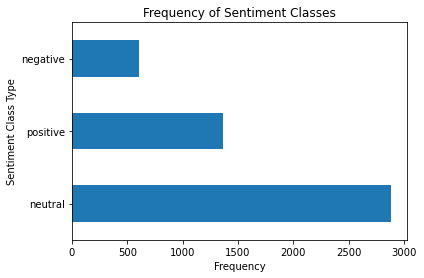

In [5]:
df['label'].value_counts().plot(kind='barh')
plt.title('Frequency of Sentiment Classes')
plt.xlabel('Frequency')
plt.ylabel('Sentiment Class Type');

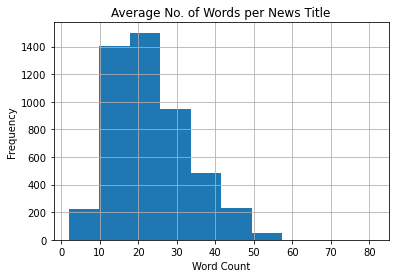

In [6]:
df['text'].apply(lambda x: len(x.split(' '))).hist()
plt.title('Average No. of Words per News Title');
plt.xlabel('Word Count');
plt.ylabel('Frequency');

## Setup Vocabulary

In [7]:
# create the English vocabulary
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

counter = Counter()
    
for _, row in df.iterrows():
    text = row['text']
    text = text.lower()
    counter.update(en_tokenizer(text))

en_vocab = Vocab(counter, max_size=40000, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_size = len(en_vocab)

In [8]:
from torch.nn.utils.rnn import pad_sequence

# map data
LABEL_MAPPING = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

INV_LABEL_MAPPING = {val: label for label, val in LABEL_MAPPING.items()}

PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

y = [torch.tensor(LABEL_MAPPING[label], dtype=torch.long) for label in df['label'].values]
X = [torch.tensor([BOS_IDX] + [en_vocab[token] for token in en_tokenizer(text)] + [EOS_IDX], dtype=torch.long) for text in df['text'].values]
X = pad_sequence(X, padding_value=PAD_IDX).T
print(X.shape)

torch.Size([4846, 90])


In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
test_data = [(xi, yi) for xi, yi in zip(X_test, y_test)]
train_data = [(xi, yi) for xi, yi in zip(X_train, y_train)]

train_size = len(train_data)
test_size = len(test_data)

In [168]:
from sklearn.utils import class_weight



In [10]:
from torch.utils.data import WeightedRandomSampler

def create_sample_weights(y_train):
    y_train_size = len(y_train)
    freq_record = {key: 0 for key in LABEL_MAPPING.values()}
    # count freq of each class
    for i in y_train:
        freq_record[int(i.numpy())] += 1
    # output placeholder
    y_train_weights = np.zeros(len(y_train))
    for i in range(y_train_weights.shape[0]):
        y_train_weights[i] = 1. / freq_record[int(y_train[i])]
#         y_train_weights[i]= 0.6667 - freq_record[int(y_train[i])]/y_train_size
    return y_train_weights
        
sample_weights = create_sample_weights(y_train)
# add sampler to tackle imbalance data issue
weight_sampler = WeightedRandomSampler(sample_weights, len(y_train), replacement=True)

In [11]:
BATCH_SIZE = 8
        
# train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=weight_sampler)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
# quick test
eg = torch.randint(vocab_size, (10,86), dtype=torch.long)
vocab_size_eg = 1000
embed = nn.Embedding(vocab_size, 64)
out = embed(eg)
out.shape

torch.Size([10, 86, 64])

## Model

In [13]:
# define model
class NewsSentiment(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers):
        super(NewsSentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim) # output -> (embedding_dim, sentence_len)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                           bidirectional=True) # output -> (embedding_dim,)
        self.fc1 = nn.Linear(hidden_size*2, 128)
        self.relu = nn.LeakyReLU
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, inx):
        out = self.embedding(inx)
        out,_ = self.lstm(out)
        out = out[:,-1,:] # only wants the last layer of the LSTM
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [17]:
# setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMBEDDING_SIZE=32
HIDDEN_SIZE=128
NUM_LAYERS=1

model = NewsSentiment(EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

## Training

In [18]:
def train_epoch():
    total_loss=0
    correct_count=0
    model.train()
    for xi, yi in train_dataloader:
        optimizer.zero_grad()
        xi = xi.to(device)
        yi = yi.to(device)
        y_hat = model(xi)
        loss = loss_function(y_hat, yi)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        correct_count += (torch.argmax(y_hat,axis=1)==yi).float().sum()
    return total_loss/train_size, correct_count/train_size
    
def evaluate():
    total_loss=0
    correct_count=0
    model.eval()
    for xi, yi in test_dataloader:
        xi = xi.to(device)
        yi = yi.to(device)
        y_hat = model(xi)
        loss = loss_function(y_hat, yi)
        total_loss += loss
        correct_count += (torch.argmax(y_hat,axis=1)==yi).float().sum()
    return total_loss/test_size, correct_count/test_size

def test(count):
    counter = 0
    with torch.no_grad():
        for xi, yi in test_dataloader:
            if counter >= count:
                break
            
            xi_np = xi.numpy()
            yi_np = yi.numpy()
            
            xi = xi.to(device)
            yi = yi.to(device)
            y_hat = model(xi)
            
            for i in range(xi.shape[0]):
                x_str = ' '.join([en_vocab.itos[i] for i in xi_np[i]])
                x_str = x_str.split('<eos')[0]
                x_str = x_str.replace('<bos> ','')
                x_str = x_str.replace('<unk>', 'X')
                y_str = INV_LABEL_MAPPING[int(yi_np[i])]

                print('x:', x_str)
                print('y_true:', y_str)

                y_hat_str = INV_LABEL_MAPPING[int(torch.argmax(y_hat[i], axis=0))]
                print('y_hat:', y_hat_str)
            
            counter += 1
            
    return xi

In [19]:
EPOCHS = 10
train_losses = []
val_losses = []

for i in range(EPOCHS):
    total_loss = 0
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = evaluate()
    print(f'Epoch {i} | train loss: {train_loss:.4f} | train acc: {train_acc:.4f} | val loss: {val_loss:.4f} | val acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch 0 | train loss: 0.1376 | train acc: 0.3338 | val loss: 0.1360 | val acc: 0.5887


RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

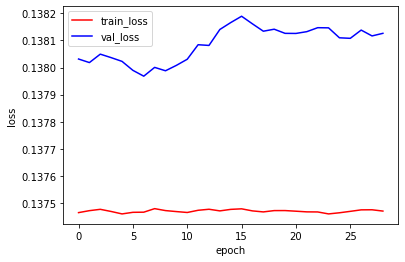

In [182]:
plt.plot(train_losses,
        color='r')
plt.plot(val_losses,
        color='b')
plt.legend(['train_loss', 'val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [164]:
eg = test(5)

x: X said plans to expand its recycled furniture business elsewhere in X , too . 
y_true: positive
y_hat: neutral
x: X - owned contract manufacturer of electronics X X X has announced plans to recruit more than 650 new staffers to fulfill new orders in X , where the company has two plants . 
y_true: positive
y_hat: neutral
x: X system supplier X -- up 24.51 pct -- was the next most heavily traded share after X X , a software house , acquired 77.4 pct of the company this morning for just under 33 mln eur . 
y_true: neutral
y_hat: neutral
x: X highest growth would be in X , while weakening demand would continue in X X , X said . 
y_true: neutral
y_hat: neutral
x: X share capital of X X X business X 1944757 - 4 is X 44,767,513.80 and it is divided into 74,612,523 shares . 
y_true: neutral
y_hat: neutral
x: X pretax profit decreased by 69.2 % to X 41.0 mn from X 133.1 mn in 2007 . 
y_true: negative
y_hat: neutral
x: X the broker repeated its ` buy ' rating , based on expectations that curr